# 2D Alignment - Maximum CC vs. Maximum-Likelihood

In [53]:
from scipy import ndimage
import scipy; import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Import test image

In [52]:
pig_raw = ndimage.imread('1_animal-1296764_960_720.png').mean(-1)
pig_bw = scipy.misc.imresize(pig_raw, (200,200)) 
pig = np.pad(pig_bw, 25, mode='constant') 
pig = (pig - pig.min()); pig = pig/pig.max()

Text(0.5,1,'Test Image - Little Piggy')

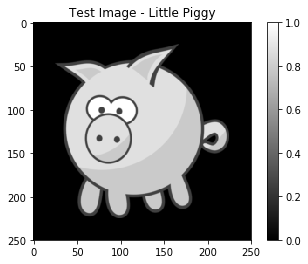

In [54]:
plt.imshow(pig, cmap='gray'); plt.colorbar()
plt.title('Test Image - Little Piggy')

## Image formation model

Images are assumed to follow the data model:

$$X_i = A + \sigma G_i$$
where $X_i$ is the i'th image, $A$ the underlying 2D image and $G_i$ a Gaussian noise term.

In [235]:
sigma = 0.5; rotation = 45
def noisify(image, sigma=1):
    return image + sigma * np.random.randn(*image.shape)
def rotate(image, angle=0):
    return ndimage.interpolation.rotate(image, angle, reshape=False)

## Generation of Reference Structure

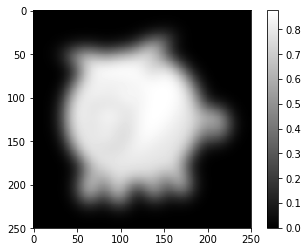

In [208]:
reference = ndimage.filters.gaussian_filter(pig, 10)
plt.imshow(reference, cmap='gray'); plt.colorbar()

## Generation of Rotated Stack

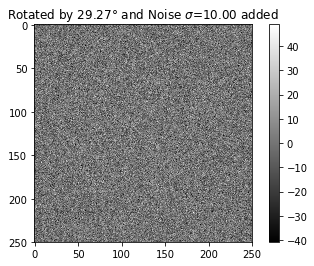

In [257]:
N = 500; sigma = 10
images_stack = []
angles = np.random.uniform(0,360,N)
for angle in angles:
    pig_rotated = rotate(pig, angle)
    pig_noisy = noisify(pig_rotated, sigma)
    images_stack.append(pig_noisy)
images_stack = np.array(images_stack)

plt.imshow(images_stack[0], cmap='gray')
plt.title('Rotated by %.2f° and Noise $\sigma$=%.2f added'%(angles[0],sigma))
plt.colorbar()

## Maximum CC / Least Squares

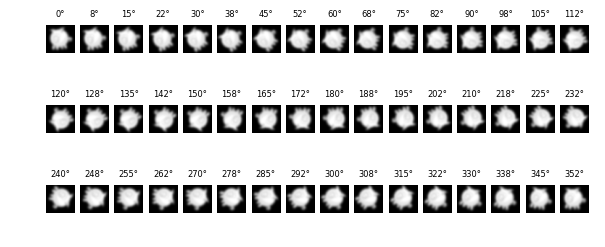

In [258]:
def rotate_reference(reference, n):
    angles = np.linspace(0,360,n,endpoint=False)
    reference_stack = []
    for angle in angles:
        reference_stack.append(rotate(reference,angle))
    return angles, np.array(reference_stack)

angular_sampling = 48
angles_reference, reference_stack = rotate_reference(reference, angular_sampling)
fig, axes = plt.subplots(3,angular_sampling//3, dpi=100, figsize=(7,3))
for angle,ax,ref in zip(angles_reference,axes.flatten(),reference_stack):
    ax.imshow(ref, cmap='gray')
    ax.set_title('%.0f°'%angle, fontsize=6); ax.axis('off')

Squared difference between observed data $X_i$ and reference $A$

$$\sum_{i=1}^N{\Vert X_i - R_{\phi i} A \Vert}^2 $$
$$= \sum_{i=1}^N{\Vert X_i \Vert^2} + \sum_{i=1}^N{ \Vert R_{\phi i} A \Vert^2} - 2\sum_{i=1}^N{X_i R_{\phi i} A}$$

Similar to CC

$$ CC =\frac{\sum_{i=1}^N{X_i R_{\phi i} A} }{N} $$

Text(0,0.5,'Correlation')

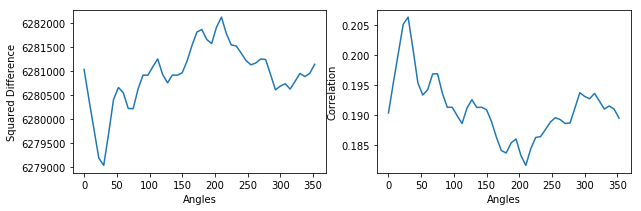

In [259]:
def sum_of_squared_difference(image, reference_stack):
    return ((image-reference_stack)**2).sum((1,2))
def correlation(image, reference_stack):
    return (image*reference_stack).mean((1,2))
fig, [ax1,ax2] = plt.subplots(1,2, figsize=(10,3))
ax1.plot(angles_reference, sum_of_squared_difference(images_stack[0], reference_stack))
ax1.set_xlabel('Angles'); ax1.set_ylabel('Squared Difference')
ax2.plot(angles_reference, correlation(images_stack[0], reference_stack))
ax2.set_xlabel('Angles'); ax2.set_ylabel('Correlation')

In [260]:
angles_max_cc = []
for image in images_stack:
    correlation_all_angles = correlation(image, reference_stack)
    angles_max_cc.append(angles_reference[correlation_all_angles.argmax()])

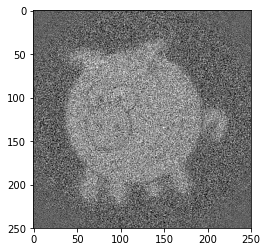

In [261]:
reconstruction = np.zeros_like(reference)
for angle_max_cc, image  in zip(angles_max_cc, images_stack):
    image_rotated = rotate(image, -angle_max_cc)
    reconstruction+= image_rotated
plt.imshow(reconstruction, cmap='gray')

Text(0,0.5,'Max_CC angles')

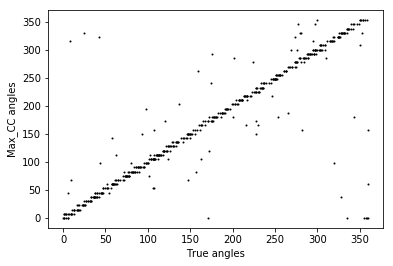

In [264]:
plt.scatter(angles, angles_max_cc, s=1, c='k')
plt.xlabel('True angles'); plt.ylabel('Max_CC angles')

Even with high noise level, the angles are detected quite reliably. Yet there are outliers here which contribute to errors in the final map. A statistical framework where a probablility weighted average is generated as an updated model will likely improve the result.

## Maximum Likelihood Method

We assume in this simplified case, that the noise level $\sigma$ is known.